# Helmholtz 1D - AutoAMG on a Fixed Domain Size

## Goal
Given the Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with periodic boundary conditions, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, and a multilevel hierarchy that is able to solve $A u = f$ fast.

In general, $k=k(x)$ varies over the domain. In thesse experiments, $k$ is constant, but we do not assume this knowledge.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. In this experiment we use a fixed periodic domain with $n=96$ points and a small $kh=0.5$.

In [299]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=5, suppress=False)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Finest-level Eigenvalues

In [242]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, _ = eig(a.todense())
lam = np.real(lam)
lam = lam[np.argsort(np.abs(lam))]
print("Smallest-magnitude eigenvalue", lam[0])

Smallest-magnitude eigenvalue -0.02393225657483029


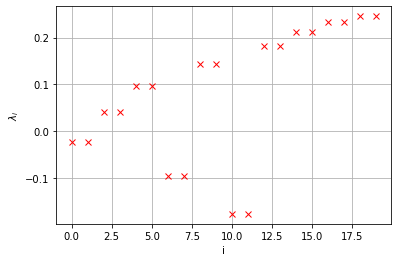

In [239]:
plt.plot(lam[:20], "rx")
plt.grid(True)
plt.xlabel("i")
plt.ylabel(r"$\lambda_i$");

## Two-level Bootstrap
We perform 4 bootstrap cycles, starting from 20 random test functions.
* R is constructed by SVD.
* P is contructed by regularized LS.
We measure the Residual to Error Ratio (RER) of test functions the two-level cycle convergence factor for $A x = 0$ (solving exactly at the coarse level), with $\nu_1+\nu_2=4$ relaxations per cycle 

In [321]:
# Fixed seed for reproducible results.
np.random.seed(0)

num_examples = 20
max_levels = 2
num_bootstrap_cycles = 4

# Initialize test functions (to random) and hierarchy at coarsest level.
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)

x_all = [None] * (num_bootstrap_cycles + 1)
i = 0
x_all[i] = x
logger.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))

# Relax vector + coarsen in first iteration; then 2-level cycle + improve hierarchy (bootstrap).
for i in range(1, num_bootstrap_cycles + 1):
    x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, max_levels, num_sweeps=10)
    x_all[i] = x

    # Test two-level cycle convergence for A*x=0.
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 4, 0).run(x)
    x0 = np.random.random((a.shape[0], ))
    y, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, x0, 30)
    logger.info("RER {:.2f} 2-level conv factor {:.2f}".format(
        norm(a.dot(x)) / norm(x), conv_factor))

INFO     RER 2.91
INFO     Coarsening level 0->1
INFO     P error: fit 0.115 val 0.259 test 0.071 alpha mean 0.005
INFO     RER 0.18 2-level conv factor 0.20
INFO     Coarsening level 0->1
INFO     P error: fit 0.036 val 0.032 test 0.008 alpha mean 0.001
INFO     RER 0.07 2-level conv factor 0.59
INFO     Coarsening level 0->1
INFO     P error: fit 0.009 val 0.008 test 0.003 alpha mean 0.000
INFO     RER 0.05 2-level conv factor 0.53
INFO     Coarsening level 0->1
INFO     P error: fit 0.018 val 0.011 test 0.003 alpha mean 0.001
INFO     RER 0.05 2-level conv factor 0.70


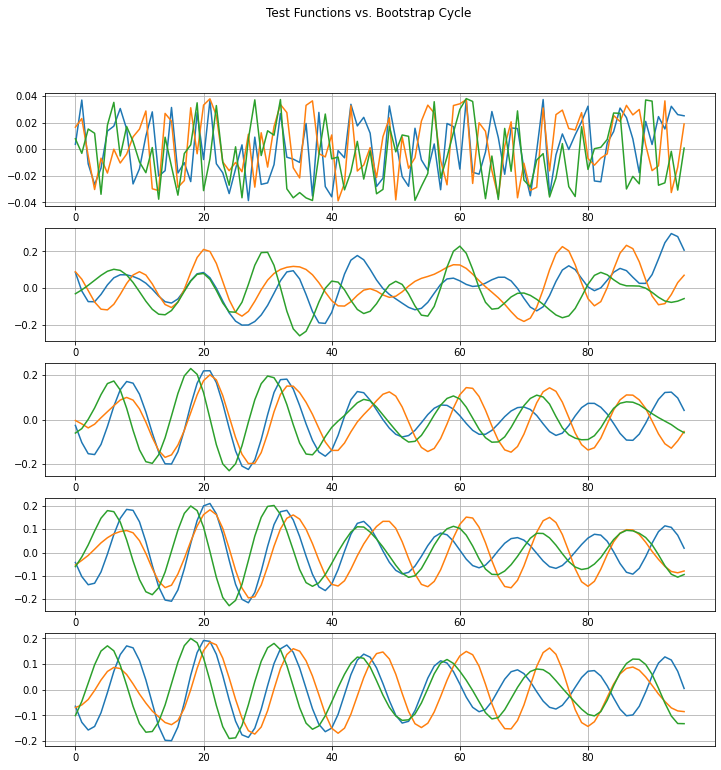

In [309]:
fig, axs = plt.subplots(len(x_all), 1, figsize=(12, 12))
fig.suptitle('Test Functions vs. Bootstrap Cycle')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

Even though the test function RER decreases, the two-level convergence factor is excellent after one bootstrap cycle, then gets worse and does not improve.

## Two-level Cycle Properties
### Fine vs. Coarse Operator Eigenvalues

In [310]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][ind]

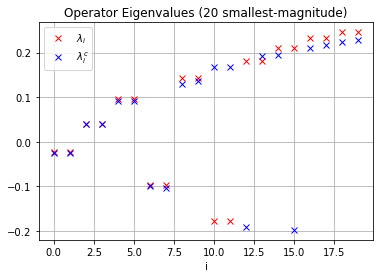

In [311]:
k = 20
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]

plt.plot(lf, 'rx', label="$\lambda_i$")
plt.plot(lc, 'bx', label="$\lambda_i^c$")
plt.xlabel("i")
plt.grid(True)
plt.title("Operator Eigenvalues ({} smallest-magnitude)".format(k));
plt.legend();
#plt.xlim([-0.3, 0.3]);
#plt.ylim([-0.1, 0.1]);

In [312]:
pd.DataFrame(np.concatenate((lf, lc, np.abs(lc - lf)/np.abs(lf)), axis=1),
            columns=("lam0", "lam1", "rel error"))

,lam0,lam1,rel error
0,-0.023932,-0.024158,0.009419
1,-0.023932,-0.024369,0.018268
2,0.040200,0.039136,0.026476
3,0.040200,0.039505,0.017286
4,0.095828,0.090695,0.053556
5,0.095828,0.091578,0.044348
6,-0.096528,-0.100126,0.037273
7,-0.096528,-0.103535,0.072583
8,0.142921,0.129959,0.090698
9,0.142921,0.137007,0.041385


The smallest $10$ eigenvalues are appoximated to $1%-10%$ error, but $\lambda_{10,11,14,15}$ arre badly approximated ($200%$ error, although looks like these pairs may be sign-flipped due to ordering eigenvalues by ascending absolute value, and might simply be swapped), so the two-level convergence is affected.

### Asymptotically Slowest Error in the Cycle
We consider a two-cycle with $(\nu=4, 0)$ relaxations and let $y$ be the slowest to converge error. That is, $y$ is the error after the Coarse-level correction (CLC). We compare $y$ and its CLC $P R y$.

In [366]:
# Fixed seed for reproducible results.
np.random.seed(0)

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 4, 0, debug=True).run(x)
x0 = np.random.random((a.shape[0], ))
y, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, x0, 14,
                                                  print_frequency=1)
logger.info("2-level conv factor {:.2f}".format(conv_factor))

INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            9.0700e-01    1.6325e+00
INFO     0        relax 4            1.5574e-01    3.2256e-01
INFO     1        initial            2.5391e-01    3.7682e-01
INFO     1        coarsest           3.2619e-16    1.9830e-15
INFO     0        correction         1.5702e-01    1.3049e+00
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            1.5702e-01    1.3049e+00
INFO     0        relax 4            5.2815e-02    5.7666e-01
INFO     1        initial            1.0293e-01    8.2612e-01
INFO     1        coarsest           9.5626e-17    1.6426e-15
INFO     0        correction         4.7575e-02    1.0921e+00
INFO     -------------------------------------------------------------------

In [367]:
# Interpolation operator.
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level._restriction_csr
print(p.shape)
print("P")
print(p.todense())

(96, 48)
P
[[ 0.27224 -0.38256  0.      ...  0.       0.02804 -0.33354]
 [ 0.59644 -0.50393  0.      ...  0.      -0.00954  0.21569]
 [ 0.61254  0.34774  0.00944 ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  0.02059 -0.66059  0.07241]
 [-0.07862  0.10627  0.      ...  0.      -0.34957 -0.62348]
 [ 0.09499 -0.14992  0.      ...  0.      -0.16882 -0.56821]]


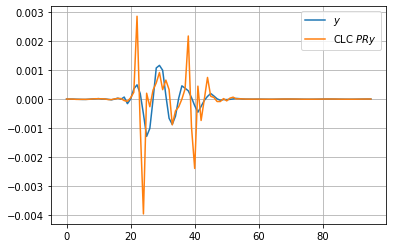

In [368]:
plt.plot(y, label="$y$")
correction = p.dot(r.dot(y))
plt.plot(correction, label="CLC $P R y$")
plt.legend()
plt.grid(True);

In [369]:
# ||P R y - y|| / ||y||
norm(p.dot(r.dot(y)) - y) / norm(y)

1.9415879838467307

In [370]:
i = np.argmax(correction)
print("argmax PRy = {}".format(i))
print("Interpolation coefficients of points {}..{}".format(i - 2, i + 2))
p[i - 2:i + 3, i // 2-4:i//2+4].todense()

argmax PRy = 22
Interpolation coefficients of points 20..24


matrix([[ 0.     ,  0.03542,  0.1546 , -0.43038, -0.4443 ,  0.     ,  0.     ,  0.     ],
        [ 0.     , -0.02641, -0.09931, -0.61011, -0.32009,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     , -0.88662,  1.24608, -0.09164, -1.07154,  0.     ],
        [ 0.     ,  0.     ,  0.     , -0.1669 ,  0.07278,  0.07339,  0.67252,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.40417, -1.02088,  0.3315 ,  1.93522,  0.     ]])

There are local interpolation errors. so how come the interpolation LS fitting process reports an excellent fit to smooth test vectors, yet there exists a $y$ for which it is bad? In this problem we know that fitting the AZMs should be good to obtain a good interpolation for all algebraically-smooth errors, so we don't need a bootstrap process that adds $y$ to the test function set. This seems more like a bug in the LS fitting.